In [1]:
import polars as pl
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wordcount_df = pl.read_csv('wordcount.txt', separator='\t', has_header=False)
# Rename the columns of the wordcount dataframe
wordcount_df = wordcount_df.rename({"column_1": "word_review", "column_2": "count"})
wordcount_df.head(10)

word_review,count
str,i64
"""aa@1002875+""",1
"""aa@1018109+""",2
"""aa@1042560""",1
"""aa@1048986""",2
"""aa@1056809+""",1
"""aa@1065270""",2
"""aa@1068690""",1
"""aa@107283""",2
"""aa@109149""",1


In [3]:
wordcount_df_split = wordcount_df.with_columns(pl.col("word_review").str.splitn("@", 2).struct.rename_fields(["word", "review_id"])
                                                 .alias("word_fields")).unnest("word_fields").select(pl.col("word"), pl.col("count"))

word_freq = wordcount_df_split.group_by('word').agg(pl.sum('count')).to_dict(as_series=False)
word_freq = {row[0]: row[1] for row in zip(word_freq['word'], word_freq['count'])}
# Drop the word "phone" from the word frequency dictionary
word_freq.pop('phone', None)

1721913

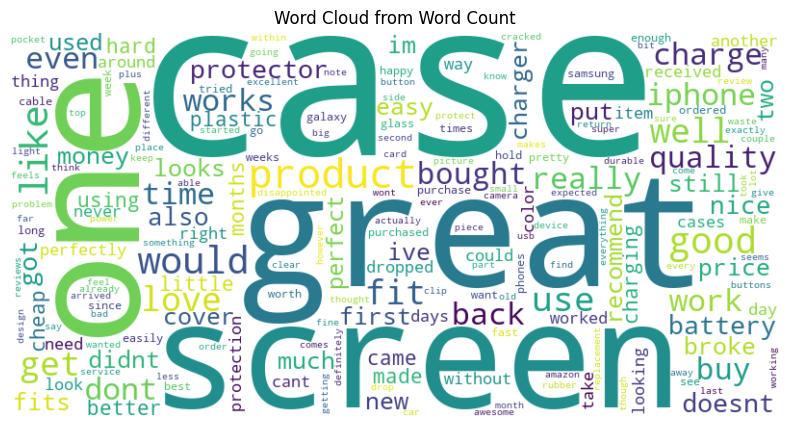

In [17]:
# Generate and display the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Word Count')
plt.show()

In [5]:
tfidf_df = pl.read_csv('tfidf.txt', separator='\t', has_header=False)
# Rename the columns of the tfidf dataframe
tfidf_df = tfidf_df.rename({"column_1": "review_word", "column_2": "tfidf"})
tfidf_df.head(10)

review_word,tfidf
str,f64
"""1068690@aa""",0.280797
"""2666482+@aa""",0.086185
"""2951334+@aa""",0.544044
"""454263@aa""",0.725392
"""1897144+@aa""",2.176176
"""670813+@aa""",0.870471
"""3062810+@aa""",0.073149
"""1979028+@aa""",0.16424
"""1001631+@aa""",0.96719


In [6]:
tfidf_df

review_word,tfidf
str,f64
"""1068690@aa""",0.280797
"""2666482+@aa""",0.086185
"""2951334+@aa""",0.544044
"""454263@aa""",0.725392
"""1897144+@aa""",2.176176
"""670813+@aa""",0.870471
"""3062810+@aa""",0.073149
"""1979028+@aa""",0.16424
"""1001631+@aa""",0.96719


In [7]:
# Split 'review_word' into 'review' and 'word'
tfidf_df_split = tfidf_df.with_columns(pl.col("review_word").str.splitn("@", 2).struct.rename_fields(["review_id", "word"])
                                                    .alias("review_word_fields")).unnest("review_word_fields").select(pl.col("review_id"), pl.col("word"), pl.col("tfidf"))

In [8]:
# Identify positive and negative sentiments
tfidf_df_split = tfidf_df_split.with_columns(
    pl.when(pl.col("review_id").str.contains("\+"))
    .then("positive")
    .otherwise("negative")
    .alias("sentiment")
)
tfidf_df_split.head(10)

C:\Users\OWNER\AppData\Local\Temp\ipykernel_33988\3537760474.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('positive')`
  pl.when(pl.col("review_id").str.contains("\+"))
C:\Users\OWNER\AppData\Local\Temp\ipykernel_33988\3537760474.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('negative')`
  pl.when(pl.col("review_id").str.contains("\+"))


review_id,word,tfidf,sentiment
str,str,f64,str
"""1068690""","""aa""",0.280797,"""negative"""
"""2666482+""","""aa""",0.086185,"""positive"""
"""2951334+""","""aa""",0.544044,"""positive"""
"""454263""","""aa""",0.725392,"""negative"""
"""1897144+""","""aa""",2.176176,"""positive"""
"""670813+""","""aa""",0.870471,"""positive"""
"""3062810+""","""aa""",0.073149,"""positive"""
"""1979028+""","""aa""",0.16424,"""positive"""
"""1001631+""","""aa""",0.96719,"""positive"""


In [9]:
# Calculate average TF-IDF for each word, separated by sentiment
avg_tfidf = tfidf_df_split.group_by(["word", "sentiment"]).agg(pl.mean("tfidf").alias("avg_tfidf"))
avg_tfidf.head(10)

word,sentiment,avg_tfidf
str,str,f64
"""flunkyerrorfil…","""negative""",0.09722
"""fitsoverall""","""positive""",0.117889
"""testimonythese…","""positive""",0.598876
"""tapewhich""","""negative""",0.499064
"""careoverall""","""positive""",0.083016
"""daysexcellent""","""positive""",0.200344
"""placesnothing""","""positive""",1.427876
"""certifiedha""","""negative""",0.325476
"""wellunable""","""negative""",2.062859


In [10]:
# Filter for top 10 words in positive and negative sentiments
top_positive = avg_tfidf.filter(pl.col("sentiment") == "positive").sort("avg_tfidf", descending=True).head(10)
top_negative = avg_tfidf.filter(pl.col("sentiment") == "negative").sort("avg_tfidf", descending=True).head(10)

In [11]:
with pl.Config(tbl_rows=1000):
    print(top_negative)

shape: (10, 3)
┌──────────────┬───────────┬───────────┐
│ word         ┆ sentiment ┆ avg_tfidf │
│ ---          ┆ ---       ┆ ---       │
│ str          ┆ str       ┆ f64       │
╞══════════════╪═══════════╪═══════════╡
│ cury         ┆ negative  ┆ 14.971906 │
│ brokeneasly  ┆ negative  ┆ 8.166494  │
│ cheapblur    ┆ negative  ┆ 7.485953  │
│ dontconsider ┆ negative  ┆ 7.485953  │
│ fraudcould   ┆ negative  ┆ 7.485953  │
│ xboz         ┆ negative  ┆ 7.485953  │
│ arend        ┆ negative  ┆ 7.485953  │
│ defficiency  ┆ negative  ┆ 7.485953  │
│ misatake     ┆ negative  ┆ 7.485953  │
│ chinsie      ┆ negative  ┆ 7.485953  │
└──────────────┴───────────┴───────────┘


In [12]:
with pl.Config(tbl_rows=1000):
    print(top_positive)

shape: (10, 3)
┌─────────────────┬───────────┬───────────┐
│ word            ┆ sentiment ┆ avg_tfidf │
│ ---             ┆ ---       ┆ ---       │
│ str             ┆ str       ┆ f64       │
╞═════════════════╪═══════════╪═══════════╡
│ pew             ┆ positive  ┆ 13.873294 │
│ blahh           ┆ positive  ┆ 11.75312  │
│ bri             ┆ positive  ┆ 9.248863  │
│ wordslove       ┆ positive  ┆ 7.485953  │
│ itemsrecommend  ┆ positive  ┆ 7.485953  │
│ happyhappyhappy ┆ positive  ┆ 7.485953  │
│ tonw            ┆ positive  ┆ 7.485953  │
│ werepretty      ┆ positive  ┆ 7.485953  │
│ creaaits        ┆ positive  ┆ 7.485953  │
│ arivedpromptly  ┆ positive  ┆ 7.485953  │
└─────────────────┴───────────┴───────────┘


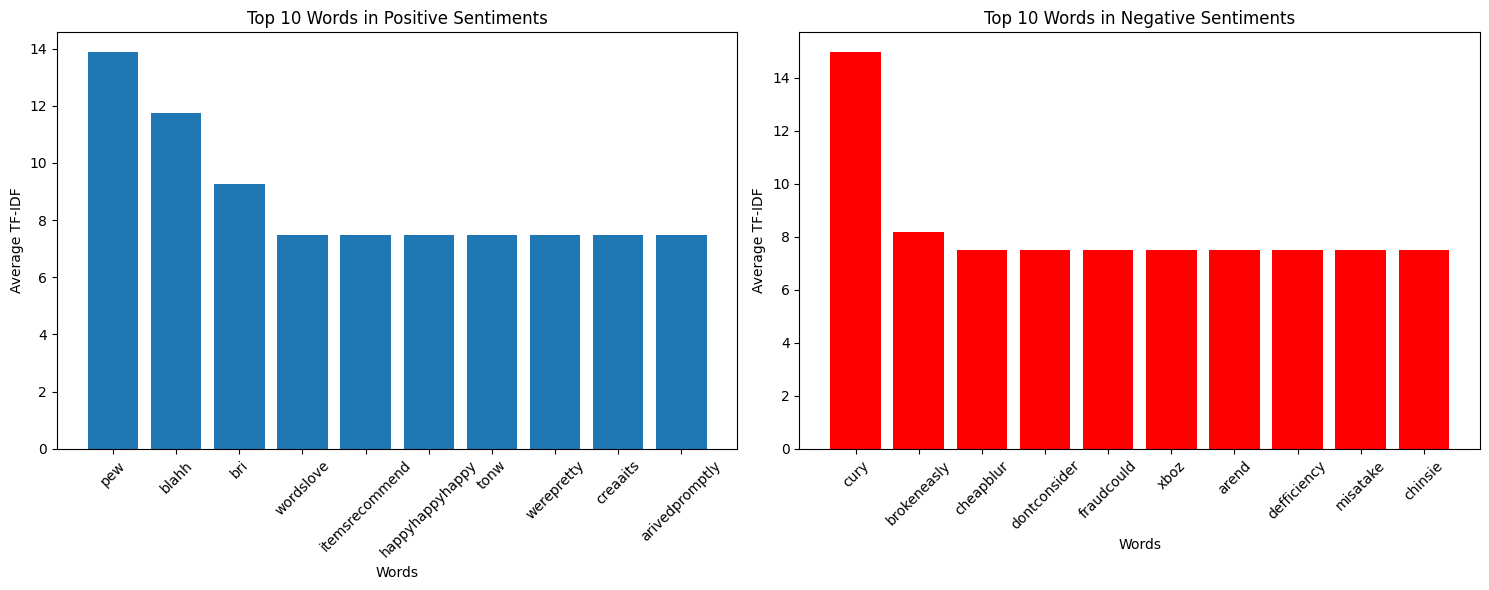

In [13]:
# Visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for positive sentiments
axes[0].bar(top_positive['word'], top_positive['avg_tfidf'])
axes[0].set_title("Top 10 Words in Positive Sentiments")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Average TF-IDF")
axes[0].tick_params(axis='x', rotation=45)

# Plot for negative sentiments
axes[1].bar(top_negative['word'], top_negative['avg_tfidf'], color='red')
axes[1].set_title("Top 10 Words in Negative Sentiments")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Average TF-IDF")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
feature_df = pl.read_csv('features.txt', separator='\t', has_header=False)
# Rename the columns of the feature dataframe
feature_df = feature_df.rename({"column_1": "review_id", "column_2": "text"})
feature_df

review_id,text
str,str
"""10+""","""brothers saver…"
"""100+""","""andor applying…"
"""100000""","""hae suppose pr…"
"""1000001""","""iq million tri…"
"""1000002+""","""convenient eve…"
"""1000013""","""thatcgoldscrge…"
"""1000014+""","""telescope frau…"
"""1000017+""","""arrives proble…"
"""1000019""","""purple protect…"


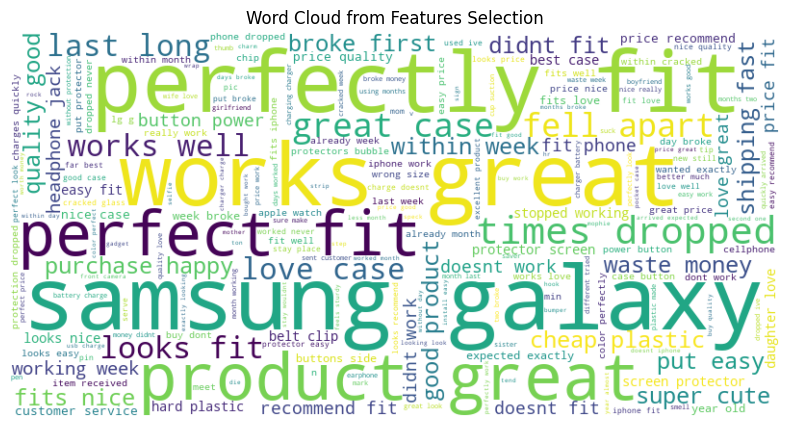

In [15]:
# Combine all texts into one string for word cloud
all_texts = ' '.join(feature_df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Features Selection')
plt.show()